# How to use the VAR model for macro fundamentals forecasts

The vector autoregressive VAR(p) model extends the AR(p) model to k series by creating a system of k equations where each contains p lagged values of all k series. The coefficients on the own lags provide information about the dynamics of the series itself, whereas the cross-variable coefficients offer some insight into the interactions across the series.

## Imports and Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error

In [3]:
sns.set(style='whitegrid',
        context='notebook',
        color_codes=True)

## Helper Functions

### Correlogram Plot

In [36]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Time Series')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1]) # q stat measures whether series is random
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF p-value: {adfuller(x)[1]:>11.2f}\n ADF Stats: {adfuller(x)[0]:>8.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

### Unit Root Test

In [37]:
def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')

## Load Data

We will extend the univariate example of a single time series of monthly data on industrial production and add a monthly time series on consumer sentiment, both provided by the Federal Reserve's data service. We will use the familiar pandas-datareader library to retrieve data from 1970 through 2017:

In [38]:
sent = 'UMCSENT'
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1970', '2019-12').dropna()
df.columns = ['sentiment', 'ip']

In [39]:
df

,sentiment,ip
DATE,,
1972-02-01,92.8,35.8607
1972-05-01,88.6,37.4516
1972-08-01,95.2,37.2129
1972-11-01,90.7,39.3828
1973-02-01,81.9,40.0094
...,...,...
2019-08-01,89.8,100.8294
2019-09-01,93.2,99.5562
2019-10-01,95.5,98.9834


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528 entries, 1972-02-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  528 non-null    float64
 1   ip         528 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB


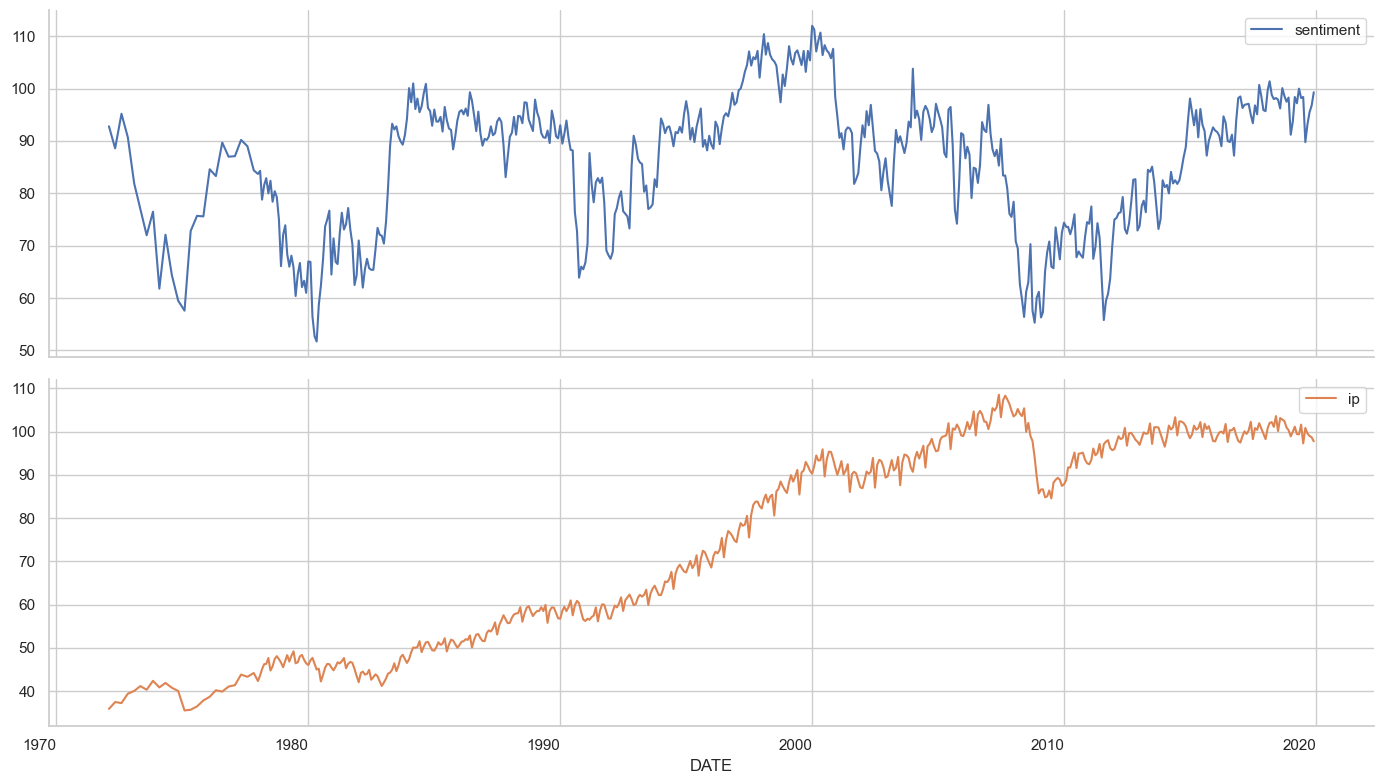

In [41]:
df.plot(subplots=True, figsize=(14,8), rot=0)
sns.despine()
plt.tight_layout();

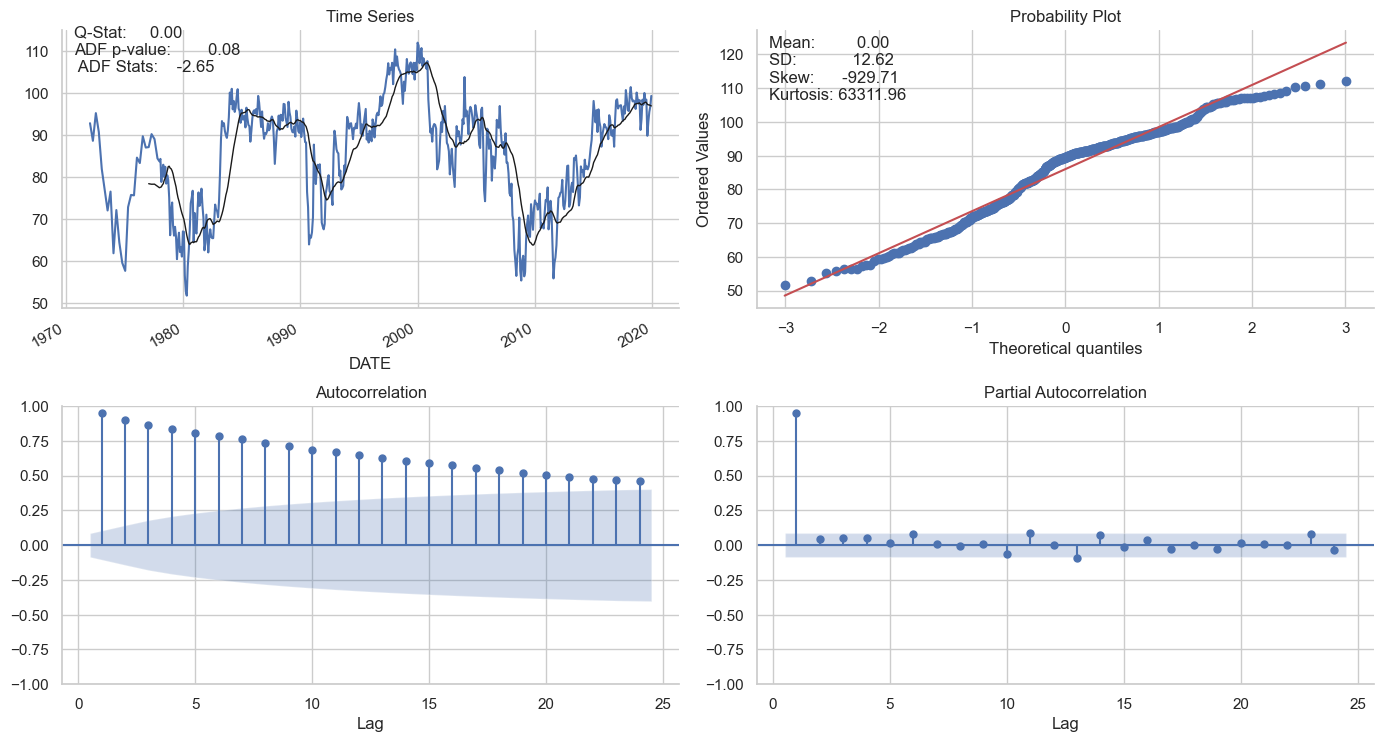

In [43]:
plot_correlogram(df.sentiment, lags=24)

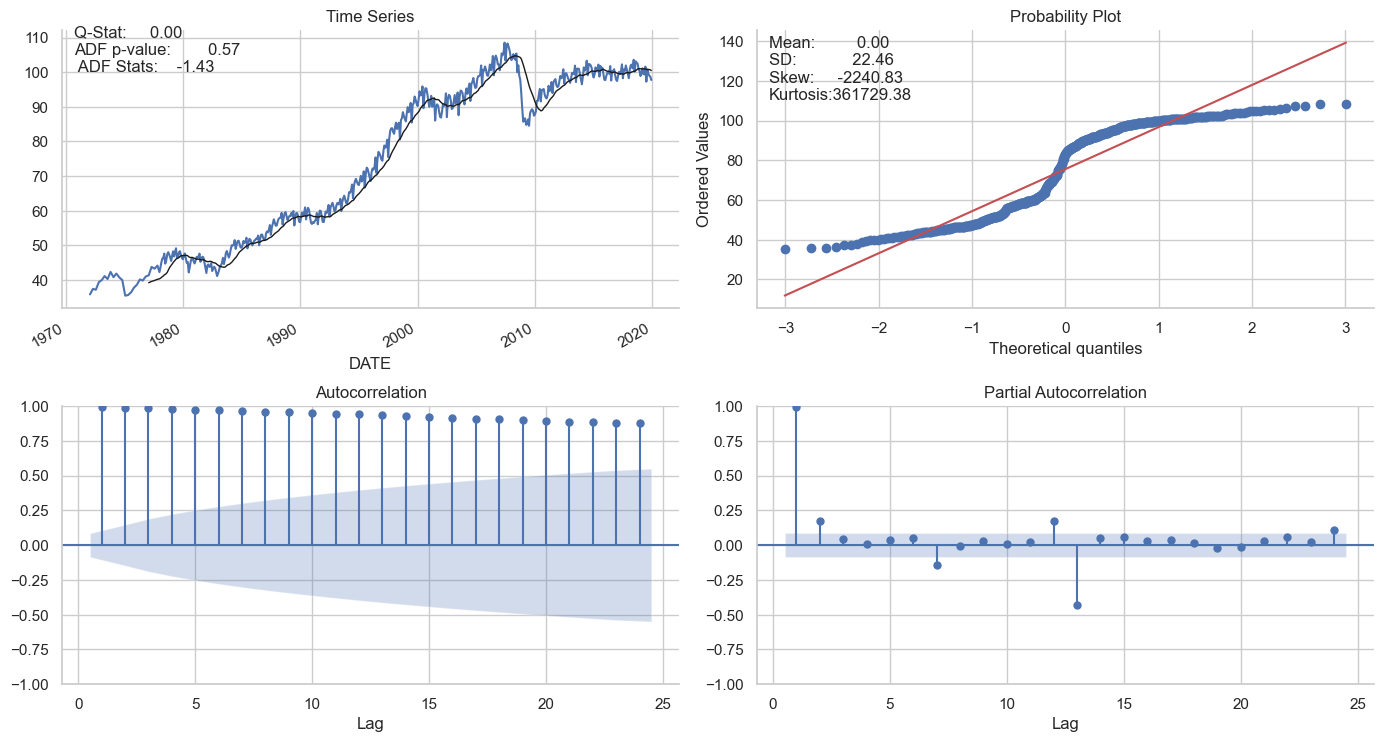

In [44]:
plot_correlogram(df.ip, lags=24)

## Stationarity Transform

Log-transforming the industrial production series and seasonal differencing using lag 12 of both series yields stationary results:

In [45]:
df_transformed = pd.DataFrame({'ip': np.log(df.ip).diff(12),
                              'sentiment': df.sentiment.diff(12)}).dropna() 

## Inspect Correlograms

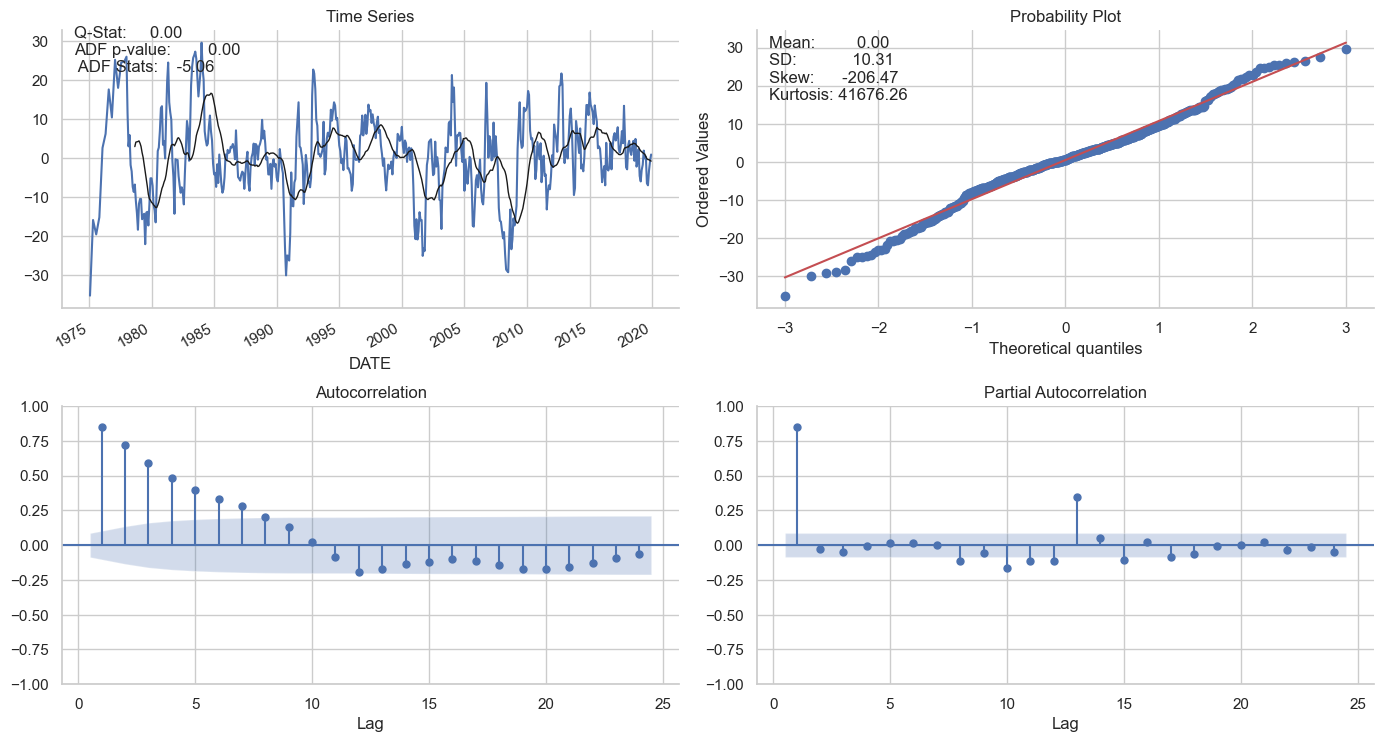

In [46]:
plot_correlogram(df_transformed.sentiment, lags=24)

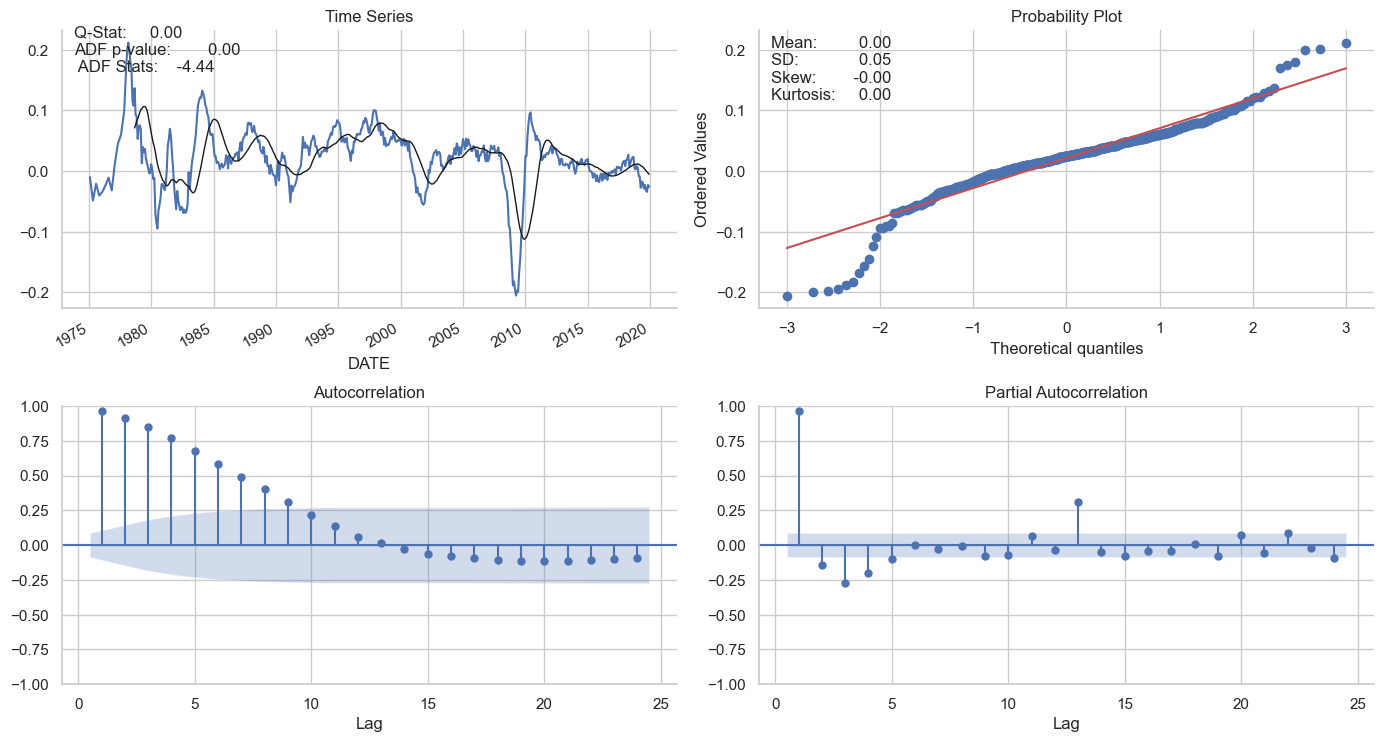

In [47]:
plot_correlogram(df_transformed.ip, lags=24)

In [48]:
df_transformed

,ip,sentiment
DATE,,
1975-02-01,-0.009940,-35.2
1975-05-01,-0.048731,-15.8
1975-08-01,-0.020879,-19.5
1975-11-01,-0.040444,-15.1
1976-02-01,-0.034130,2.7
...,...,...
2019-08-01,-0.022493,-6.4
2019-09-01,-0.031668,-6.9
2019-10-01,-0.034233,-3.1


In [49]:
test_unit_root(df_transformed)

,p-value
ip,0.02%
sentiment,0.00%


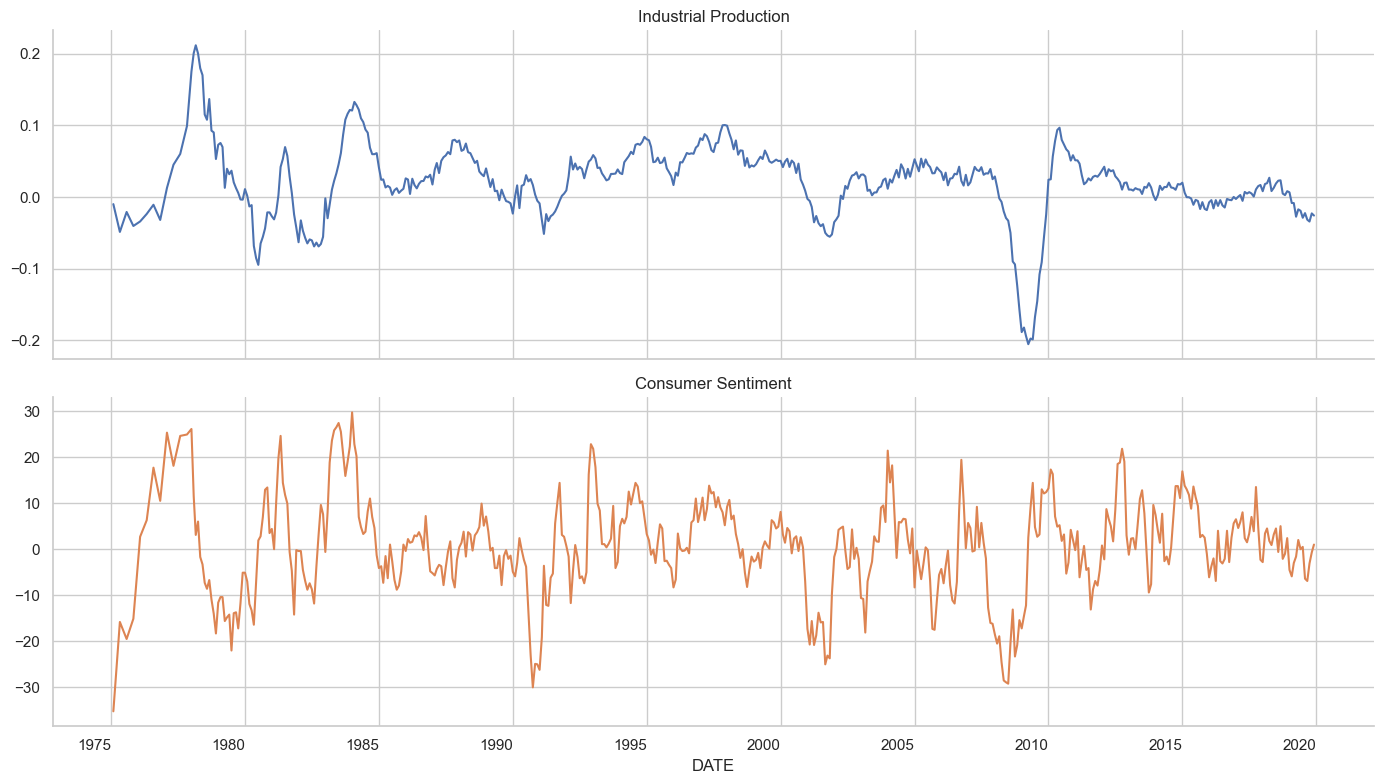

In [50]:
df_transformed.plot(subplots=True, figsize=(14, 8),
                    title=['Industrial Production', 'Consumer Sentiment'],
                    legend=False,
                    rot=0)
sns.despine()
plt.tight_layout()

## VAR Model

To limit the size of the output, we will just estimate a VAR(1) model using the statsmodels VARMAX implementation (which allows for optional exogenous variables) with a constant trend through 2017. The output contains the coefficients for both time series equations.

In [55]:
df_transformed = df_transformed.apply(minmax_scale) # (x - x_min) / (x_max - x_min), scaling to [0, 1]

In [56]:
df_transformed

,ip,sentiment
DATE,,
1975-02-01,0.468526,0.000000
1975-05-01,0.375588,0.298921
1975-08-01,0.442319,0.241911
1975-11-01,0.395444,0.309707
1976-02-01,0.410570,0.583975
...,...,...
2019-08-01,0.438451,0.443760
2019-09-01,0.416469,0.436055
2019-10-01,0.410323,0.494607


In [72]:
df_transformed[:"2017"]

,ip,sentiment
DATE,,
1975-02-01,0.468526,0.000000
1975-05-01,0.375588,0.298921
1975-08-01,0.442319,0.241911
1975-11-01,0.395444,0.309707
1976-02-01,0.410570,0.583975
...,...,...
2017-08-01,0.504125,0.650231
2017-09-01,0.493944,0.602465
2017-10-01,0.517838,0.750385


In [58]:
model = VARMAX(df_transformed.loc[:'2017'], order=(1,1), trend='c').fit(maxiter=1000)
# we have two variables, so lag order 1 means 2 lags in total
# for example 
# sentiment_t = c + a1*sentiment_t-1 + a2*ip_t-1 + b1*et-1 + b2*ei-1 + et

C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [59]:
print(model.summary())

                            Statespace Model Results                           
Dep. Variable:     ['ip', 'sentiment']   No. Observations:                  492
Model:                      VARMA(1,1)   Log Likelihood                1556.685
                           + intercept   AIC                          -3087.370
Date:                 Wed, 26 Nov 2025   BIC                          -3032.789
Time:                         15:56:39   HQIC                         -3065.938
Sample:                              0                                         
                                 - 492                                         
Covariance Type:                   opg                                         
Ljung-Box (L1) (Q):             0.23, 0.42   Jarque-Bera (JB):        152.63, 16.85
Prob(Q):                        0.63, 0.52   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.46, 1.02   Skew:                       0.17, 0.21
Prob(H) (two-sided):        

### Plot Diagnostics

`statsmodels` provides diagnostic plots to check whether the residuals meet the white noise assumptions, which are not exactly met in this simple case:

#### Industrial Production

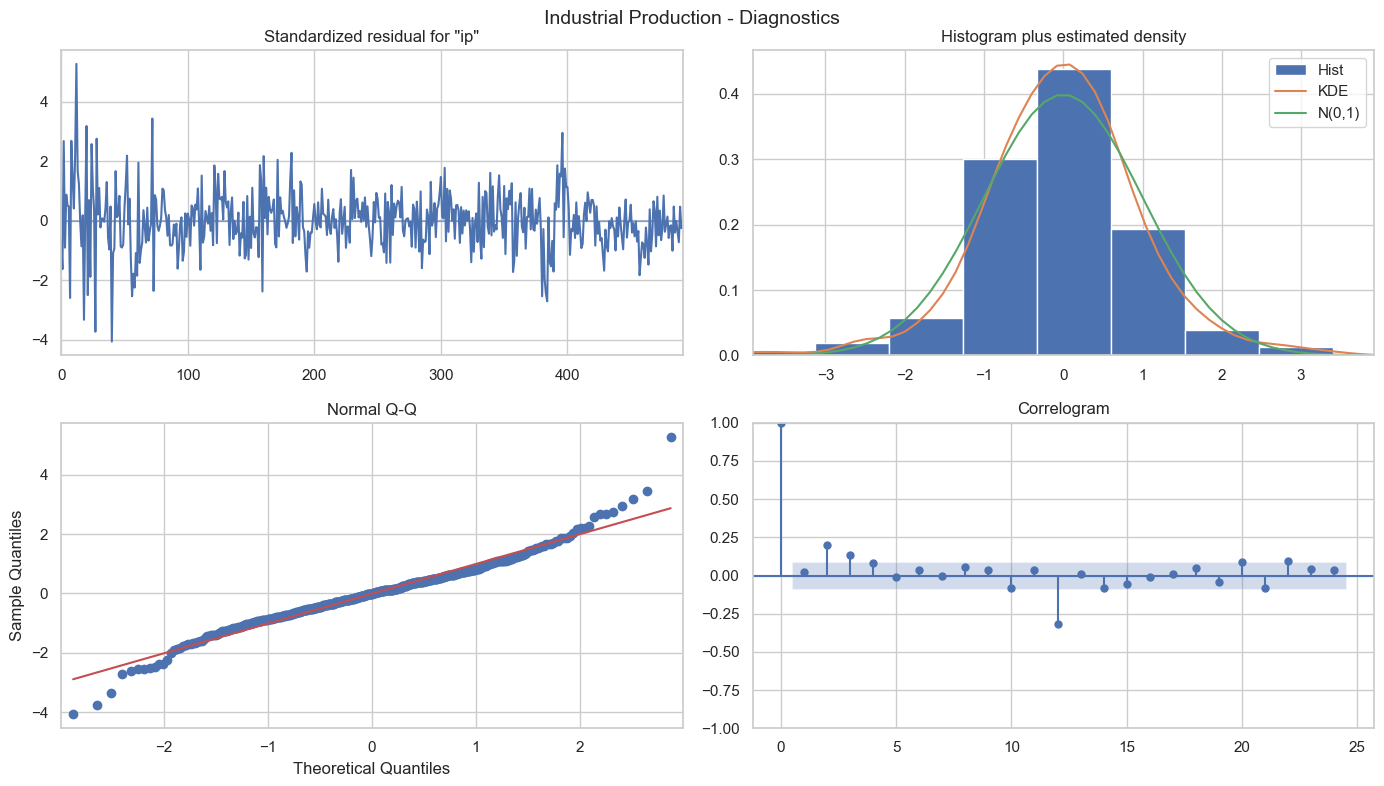

In [60]:
model.plot_diagnostics(variable=0, figsize=(14,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

#### Sentiment

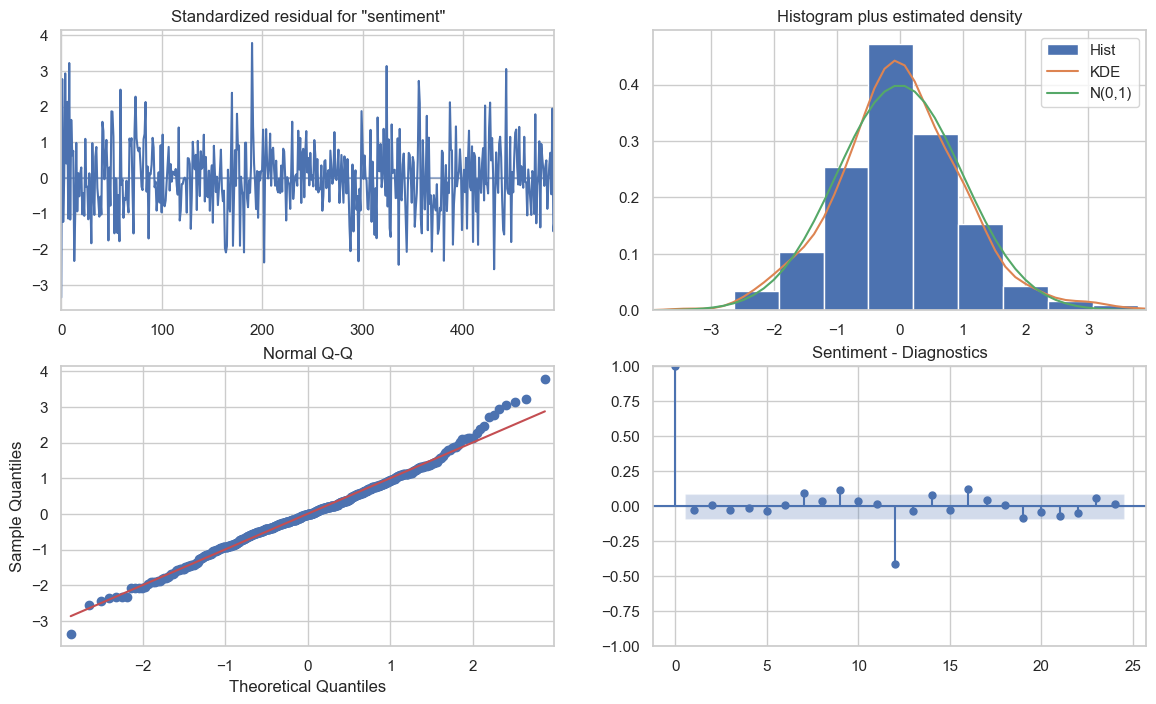

In [61]:
model.plot_diagnostics(variable=1, figsize=(14,8), lags=24)
plt.title('Sentiment - Diagnostics');

In [62]:
### Impulse-Response Function

In [63]:
df_transformed

,ip,sentiment
DATE,,
1975-02-01,0.468526,0.000000
1975-05-01,0.375588,0.298921
1975-08-01,0.442319,0.241911
1975-11-01,0.395444,0.309707
1976-02-01,0.410570,0.583975
...,...,...
2019-08-01,0.438451,0.443760
2019-09-01,0.416469,0.436055
2019-10-01,0.410323,0.494607


### Generate Predictions

Out-of-sample predictions can be generated as follows:

In [77]:
n =len(df_transformed)
start = n-24

preds = model.predict(start=start+1, end=n)

C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


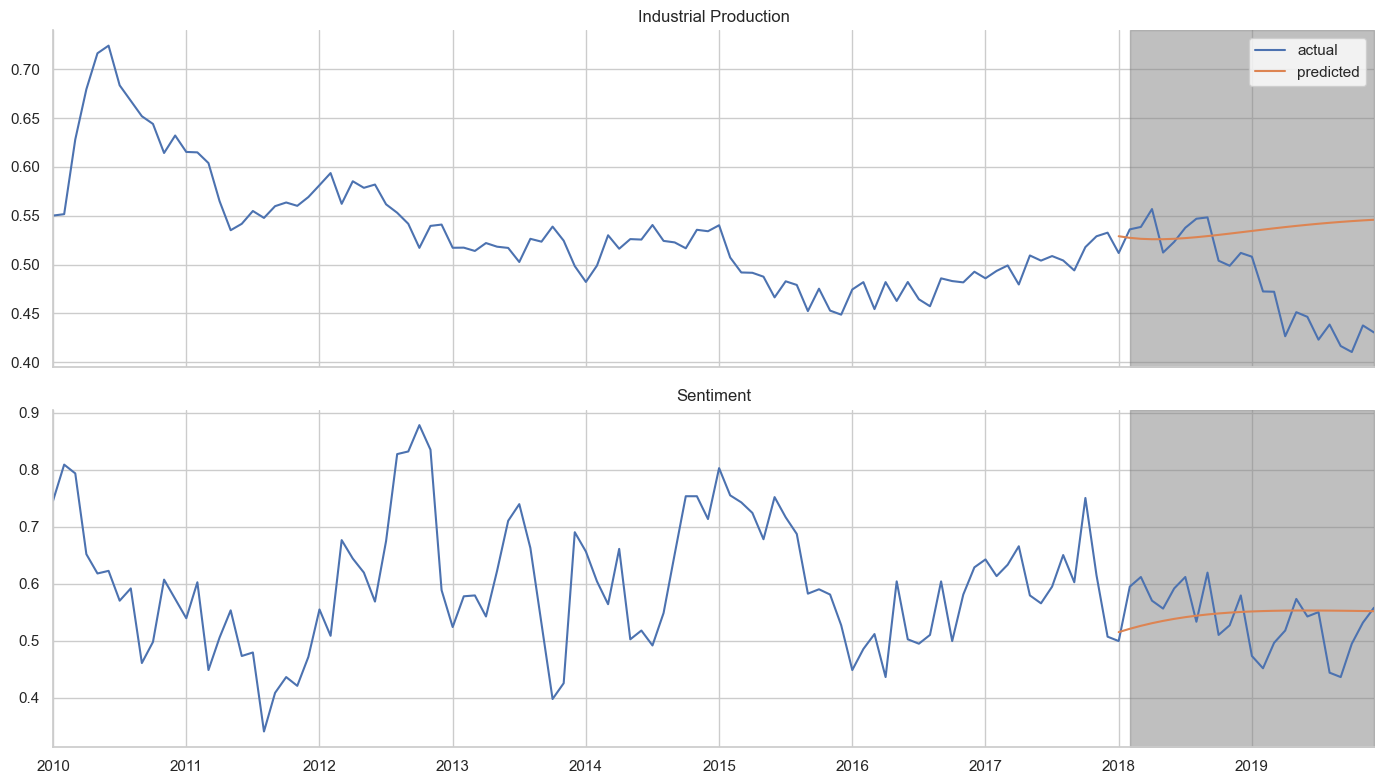

In [78]:
preds.index = df_transformed.index[start:]

fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed.ip.loc['2010':].plot(ax=axes[0], label='actual', title='Industrial Production')
preds.ip.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.sentiment.loc['2010':].plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();

### Out-of-sample forecasts

A visualization of actual and predicted values shows how the prediction lags the actual values and does not capture non-linear out-of-sample patterns well:

In [79]:
forecast = model.forecast(steps=24)

C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


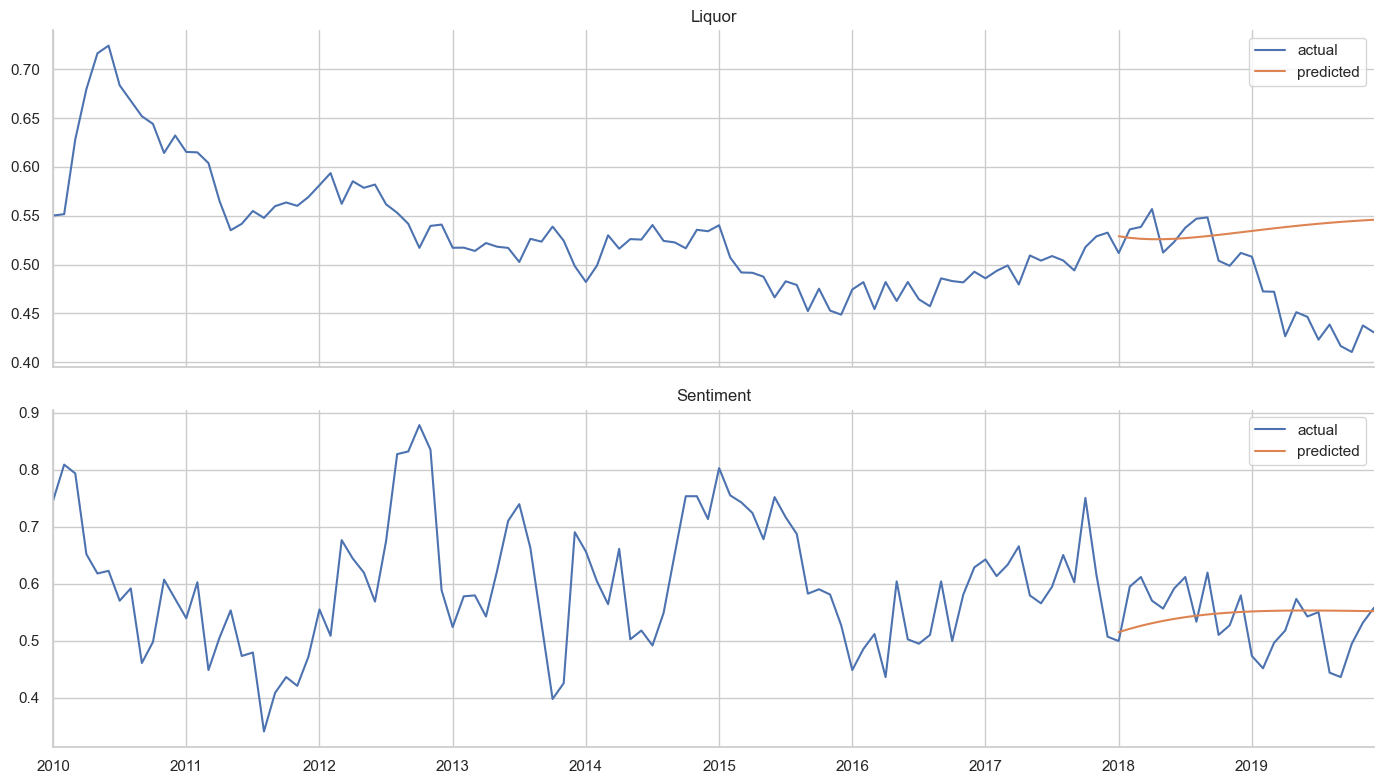

In [80]:
# you can see from the graph that actual series move up and down quickly but predicted series move smoothly, so it is lagging behind actual series, stays almost flat and can't really capuure non-linear movements
fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed['2010':].ip.plot(ax=axes[0], label='actual', title='Liquor')
preds.ip.plot(label='predicted', ax=axes[0])
axes[0].legend()

df_transformed['2010':].sentiment.plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].legend()
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();

In [81]:
mean_absolute_error(forecast, df_transformed.iloc[492:])

0.052478587630609516